In [2]:
import pandas as pd
import os
import time
import json
import math
import numpy
import matplotlib.pyplot as plt

In [ ]:
#read in the results, do not open in Excel. Saving in Excel will delete the results as they are appended to the end of the file but Excel has a max of rows, which is exceeded here.
df = pd.read_csv('results_gptmini_16M.csv')
df.info()

In [15]:
df_text = df.dropna(subset=['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'text', 'Sentiment'])
df_sentiment = df.dropna(subset=['line_id', 'content'])

In [16]:
df_text = df_text.reset_index(drop=True)
df_sentiment = df_sentiment.reset_index(drop=True)

In [ ]:
#place the results to the corresponding tweet, as the results were appended in order below the tweets
result_df = pd.concat([df_text, df_sentiment[['line_id', 'content']]], axis=1)
result_df

In [ ]:
#Remove the last 2088 rows as the last batch failed and there are no scores available.
result_df = result_df[:1080200]
result_df

In [ ]:
result_df.columns = ['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'text', 'Sentiment', 'line_id1', 'content1', 'line_id2', 'content2']
result_df

In [ ]:
results_df = result_df.drop(columns=['line_id1', 'content1'])

In [ ]:
#change all the rows from the content column to 0.0 if it does not start with '0.'
#result_df['content'] = result_df['content'].astype(str)

#result_df.loc[~result_df['content'].str.startswith('0.', na=False), 'content'] = '0.0'

# Convert the 'content' column to float
result_df['content2'] = result_df['content2'].apply(pd.to_numeric, errors='coerce').fillna(0.0)

result_df

In [ ]:
#from the polarity score, create a sentiment score (1, 0, -1)
def floor_ceil(value):
    if value < 0.0:
        return math.floor(value)
    elif value > 0.0:
        return math.ceil(value)
    else:
        return value

#Transform GPT polarity score to sentiment score
result_df['simple_score'] = result_df['content2'].apply(floor_ceil)
result_df

In [ ]:
#check how many positive, neutral and negative tweets there are
result_df['simple_score'].value_counts()

In [3]:
df_manual = pd.read_csv('bitcoin_1000_random1.csv')

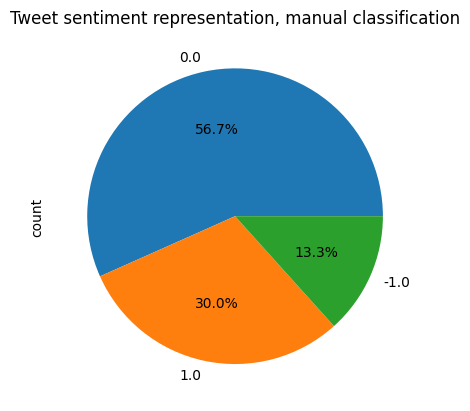

In [4]:
#A pie chart of the positive, neutral and negative tweets
df_manual['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Tweet sentiment representation, manual classification')
plt.show()

In [ ]:
#Aggregate the scores by date
aggregate_df = result_df.groupby('Date').agg({'content2': 'sum', 'simple_score': 'sum'}).reset_index()
aggregate_df

In [ ]:
#Make normalized scores as some days have more tweets than others
aggregate_df['normalized_score'] = result_df.groupby('Date')['content2'].transform('mean')
aggregate_df['normalized_simple_score'] = result_df.groupby('Date')['simple_score'].transform('mean')
aggregate_df

In [ ]:
aggregate_df['date_count'] = result_df.groupby('Date')['Date'].transform('count')
aggregate_df

In [ ]:
unwanted_col = ['normalized_score', 'normalized_simple_score', 'date_count']
aggregate_df.drop(unwanted_col, axis=1)

In [54]:
#date_counts.to_csv('date_counts_16M.csv')

In [ ]:
date_counts = pd.read_csv('date_counts_16M.csv')
date_counts

In [ ]:
date_counts = pd.read_csv('date_counts_16M.csv')
aggregate_df = pd.merge(aggregate_df, date_counts, on='Date', how='left')
aggregate_df

In [ ]:
unwanted_cols = ['Unnamed: 0_x', 'Unnamed: 0_y', 'count_x']
aggregate_df.drop(unwanted_cols, axis=1)
aggregate_df

In [ ]:
#normalize the scores by dividing the content2 column by the date count column
#the aggregated data already contains the the amount of tweets per day (column 'count_y')
aggregate_df['normalized_score'] = aggregate_df['content2'] / aggregate_df['count_y']
aggregate_df

In [79]:
prices = pd.read_csv('BTC-USD_2016-2019.csv')

In [ ]:
#Merge the aggregated dataframe with the price dataframe
prices = pd.merge(prices, aggregate_df, on='Date', how='left')
prices

In [ ]:
unwanted_col = ['Open', 'High', 'Low', 'Adj Close', 'Unnamed: 0_x', 'Unnamed: 0_y', 'count_x']
prices = prices.drop(unwanted_col, axis=1)
prices

In [3]:
prices2 = pd.read_csv('Merged_dataset_16M.csv')

In [ ]:
#name the index column 'id'
prices.index.name = 'id'
prices

In [14]:
#create a column with previous day volumes and different lags for the sentiment scores
previous_volume = prices['Volume'].shift(1)
prices['previous_volume'] = previous_volume
prices['previous_day_simple_sentiment'] = prices['simple_score'].shift(1)
prices['previous_3day_simple_sentiment'] = prices['simple_score'].shift(3)
prices['previous_5day_simple_sentiment'] = prices['simple_score'].shift(5)
prices['previous_7day_simple_sentiment'] = prices['simple_score'].shift(7)
prices['previous_10day_simple_sentiment'] = prices['simple_score'].shift(10)

#prices['normalized_sent_score'] = aggregate_df['simple_score'] / aggregate_df['count_y']

In [ ]:
#add lagged versions of the gpt-polarity score
prices['previous_day_sentiment'] = prices['normalized_score'].shift(1)
prices['previous_3day_sentiment'] = prices['normalized_score'].shift(3)
prices['previous_5day_sentiment'] = prices['normalized_score'].shift(5)
prices['previous_7day_sentiment'] = prices['normalized_score'].shift(7)
prices['previous_10day_sentiment'] = prices['normalized_score'].shift(10)

In [ ]:
#read in the VADER scores
vader_df = pd.read_csv('VADER_scores_cleaned_16M.csv')
vader_df

In [3]:
#name first column 'id'
vader_df.index.name = 'id'

In [ ]:
unwanted_columns = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'text', 'Sentiment', 'cleanText']
vader_df.drop(unwanted_columns, axis=1, inplace=True)
vader_df

In [ ]:
#aggregate the VADER scores per date
aggregated_vader_df = vader_df.groupby('Date').agg({'sentiment_score': 'sum'}).reset_index()
aggregated_vader_df

In [ ]:
#Add VADER scores to merged dataframe
prices = pd.merge(prices, aggregated_vader_df, on='Date', how='left')
prices

In [ ]:
prices.rename(columns={'sentiment_score': 'VADER_sentiment'}, inplace=True)
prices.head()

In [ ]:
#Add normalised VADER scores
prices['VADER_norm'] = prices['VADER_sentiment'] / prices['count_y']

In [ ]:
#Add lagged versions of the VADER scores and its normalised version
prices['VADER_1'] = prices['VADER_sentiment'].shift(1)
prices['VADER_3'] = prices['VADER_sentiment'].shift(3)
prices['VADER_5'] = prices['VADER_sentiment'].shift(5)
prices['VADER_7'] = prices['VADER_sentiment'].shift(7)
prices['VADER_10'] = prices['VADER_sentiment'].shift(10)

prices['VADER_norm1'] = prices['VADER_norm'].shift(1)
prices['VADER_norm3'] = prices['VADER_norm'].shift(3)
prices['VADER_norm5'] = prices['VADER_norm'].shift(5)
prices['VADER_norm7'] = prices['VADER_norm'].shift(7)
prices['VADER_norm10'] = prices['VADER_norm'].shift(10)

In [16]:
prices.to_csv('merged_dataset_additional_features.csv')